In [2]:
import sys
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker

import mavenn

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

Matplotlib is building the font cache; this may take a moment.


In [3]:
with open('splimlib_mave.pickle', 'rb') as f:
    df_sml = pickle.load(f)

In [4]:
df_sml.head()

,mutations,ct_2,ct_1,ct_0,sequences
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV


In [5]:
df_sml.describe()

,ct_2,ct_1,ct_0
count,386031.000000,386031.000000,386031.000000
mean,12.008556,7.701433,15.616425
std,45.869569,12.625967,8.688312
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,10.000000
50%,0.000000,1.000000,14.000000
75%,0.000000,12.000000,20.000000
max,1185.000000,165.000000,95.000000


Convert the absolute read counts into percentages.

In [20]:
df_per = df_sml
df_per[['per_2', 'per_1', 'per_0']] = df_sml[['ct_2', 'ct_1', 'ct_0']].div(df_sml[['ct_2', 'ct_1', 'ct_0']].sum(axis=1), axis=0).mul(100).round(3)
df_per.head()

,mutations,ct_2,ct_1,ct_0,sequences,per_2,per_1,per_0
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM,96.814,2.696,0.490
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM,90.390,8.108,1.502
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII,98.900,0.220,0.880
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI,97.596,0.328,2.077
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV,94.218,3.640,2.141


Perhaps the training results will be better by biasing the training set towards the top / more active variants. Construct 4 sections, sorted by high gate (ct_2):
- above wt (ct_2 > 50): place 75% in training set
- 
- 
- very low (ct_2 3 or less): place 5

In [13]:
df_sml.loc[(df_sml['ct_2'] <= 50) & (df_sml['ct_2'] > 5)].describe()

,ct_2,ct_1,ct_0
count,9048.000000,9048.000000,9048.000000
mean,24.998121,6.874337,9.936229
std,14.434191,11.449700,7.395312
min,6.000000,0.000000,0.000000
25%,11.000000,0.000000,5.000000
50%,24.000000,2.000000,9.000000
75%,38.000000,9.000000,14.000000
max,50.000000,165.000000,65.000000


In [21]:
from sklearn.model_selection import train_test_split

In [30]:
data_df = df_per

In [31]:
x = data_df['sequences'].values
y = data_df[['per_0', 'per_1', 'per_2']].values

In [38]:
L = len(data_df['sequences'][0])
y_cols = data_df.columns[5:]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=6, Y=3


In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=11056)

In [41]:
len(x_train), len(x_test), len(y_train), len(y_test)

(308824, 77207, 308824, 77207)

In [42]:
# Show dataset sizes
print(f'Training set size: {len(x_train):6,d} observations')
print(f'Test set size    : {len(x_test):6,d} observations')

Training set size: 308,824 observations
Test set size    : 77,207 observations


In [43]:
sml_alphabet = np.array(['A','G','P','Y','D','K','M','V','I','L','F','W','Δ'])

In [44]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='additive',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('splimlib_mpa_additive')

N = 308,824 observations set as training data.
Using 20.1% for validation.
Data shuffled.
Time to set data: 5.6 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has   246834 rows  and       78 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       78

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  3.264e+02  6.242e+04   1.0e+00  5.9e-01
     1  1.22528e-01  2.637e+02  5.333e+03   8.1e-01  6.2e-02  3.2e+02  1.0e+00
     2  6.14887e-02  2.617e+02  6.636e+02   8.0e-01  7.0e-03  3.6e+02  2.0e+00
     3  5.43015e-02  2.616e+02  3.563e+02   8.0e-01  3.6e-03  3.8e+02  3.1e+00
     4  4.57015e-02  2.616e+02  2.535e+02   8.0e-01  2.4e-03  4.0e+02  3.5e+00
     5  3.93426e-02  2.616e+02  2.210e+02   8.0e-01  2.0e-03  4.2e+02  5.9e+00
     6  2.43643e-02  2.615e+02  1.715e+02   8.0e-01  1.5e-03  4.4e+02  6.7e+00
     7  3.09447e-03  2.615e+02  7.26

Model loaded from these files:
	splimlib_mpa_additive.pickle
	splimlib_mpa_additive.h5


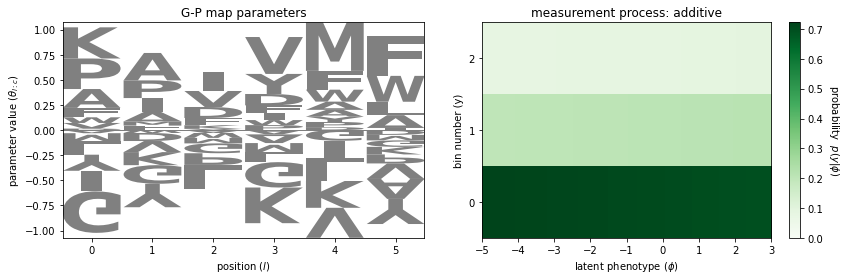

In [45]:
model = mavenn.load('splimlib_mpa_additive')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: additive')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimlib_additive_g-p_map_mpa_visualization.png')
plt.show()

In [46]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='pairwise',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('splimlib_mpa_pairwise')

N = 308,824 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 5.53 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has   247251 rows  and       78 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       78

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  3.258e+02  6.240e+04   1.0e+00  5.9e-01
     1  1.24341e-01  2.632e+02  5.171e+03   8.1e-01  6.0e-02  3.2e+02  1.0e+00
     2  6.57736e-02  2.612e+02  6.331e+02   8.0e-01  6.6e-03  3.6e+02  2.0e+00
     3  5.86544e-02  2.612e+02  3.418e+02   8.0e-01  3.4e-03  3.8e+02  3.1e+00
     4  4.97753e-02  2.611e+02  2.490e+02   8.0e-01  2.4e-03  4.0e+02  3.6e+00
     5  4.38546e-02  2.611e+02  2.188e+02   8.0e-01  2.0e-03  4.2e+02  6.0e+00
     6  2.73955e-02  2.611e+02  1.654e+02   8.0e-01  1.4e-03  4.4e+02  6.6e+00
     7  6.80589e-03  2.610e+02  6.3

Model loaded from these files:
	splimlib_mpa_pairwise.pickle
	splimlib_mpa_pairwise.h5


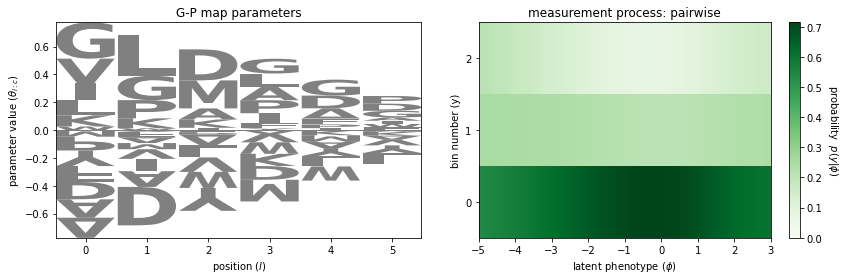

In [47]:
# Load model
model = mavenn.load('splimlib_mpa_pairwise')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: pairwise')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimlib_pairwise_g-p_map_mpa_visualization.png')
plt.show()

In [48]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='neighbor',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('splimlib_mpa_neighbour')

N = 308,824 observations set as training data.
Using 20.1% for validation.
Data shuffled.
Time to set data: 5.96 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has   246892 rows  and       78 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       78

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  3.260e+02  6.244e+04   1.0e+00  5.9e-01
     1  1.25493e-01  2.633e+02  5.198e+03   8.1e-01  6.1e-02  3.2e+02  1.0e+00
     2  6.90154e-02  2.613e+02  5.798e+02   8.0e-01  6.1e-03  3.6e+02  2.0e+00
     3  6.34827e-02  2.613e+02  3.242e+02   8.0e-01  3.3e-03  3.8e+02  3.1e+00
     4  5.51680e-02  2.613e+02  2.359e+02   8.0e-01  2.2e-03  4.0e+02  3.6e+00
     5  4.90503e-02  2.612e+02  2.058e+02   8.0e-01  1.9e-03  4.2e+02  6.0e+00
     6  3.42083e-02  2.612e+02  1.571e+02   8.0e-01  1.4e-03  4.4e+02  6.5e+00
     7  1.48526e-02  2.612e+02  6.1

Model loaded from these files:
	splimlib_mpa_neighbour.pickle
	splimlib_mpa_neighbour.h5


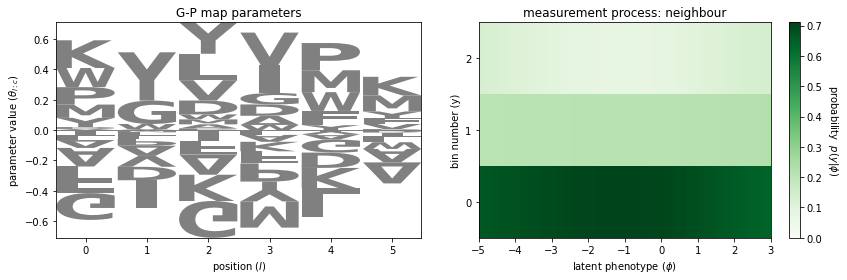

In [49]:
# Load model
model = mavenn.load('splimlib_mpa_neighbour')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: neighbour')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimlib_neighbour_g-p_map_mpa_visualization.png')
plt.show()

In [50]:
# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet=sml_alphabet,
                     gpmap_type='blackbox',
                     gpmap_kwargs={
                         'hidden_layer_sizes': [5]*5
                     })

# Set training data
model.set_data(x=x_train,
               y=y_train,
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

# Save model
model.save('splimlib_mpa_blackbox')

N = 308,824 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 6.06 sec.
Epoch 1/1000
495/495 [==============================] - 3s 7ms/step - loss: 40194.3906 - I_var: -0.0091 - val_loss: 39656.8906 - val_I_var: 0.0063
Epoch 2/1000
495/495 [==============================] - 3s 6ms/step - loss: 39966.8398 - I_var: -0.0026 - val_loss: 39659.8633 - val_I_var: 0.0062
Epoch 3/1000
495/495 [==============================] - 3s 6ms/step - loss: 39953.5859 - I_var: -0.0024 - val_loss: 39651.8516 - val_I_var: 0.0063
Epoch 4/1000
495/495 [==============================] - 3s 6ms/step - loss: 39946.0625 - I_var: -0.0022 - val_loss: 39755.7930 - val_I_var: 0.0033
Epoch 5/1000
495/495 [==============================] - 3s 6ms/step - loss: 39943.0742 - I_var: -0.0021 - val_loss: 39665.2305 - val_I_var: 0.0059
Epoch 6/1000
495/495 [==============================] - 3s 6ms/step - loss: 39941.1094 - I_var: -0.0021 - val_loss: 39658.7461 - val_I_var: 0.0060


Model loaded from these files:
	splimlib_mpa_blackbox.pickle
	splimlib_mpa_blackbox.h5


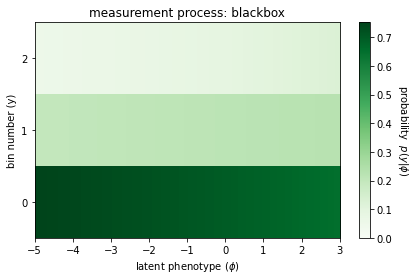

In [51]:
# Load model
model = mavenn.load('splimlib_mpa_blackbox')

# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,4])

im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process: blackbox')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('splimbli_blackbox_mpa_visualization.png')
plt.show()

In [ ]:
# Show training history
print('On test data:')
x_test = df_sml['sequences'].values
y_test = df_sml[y_cols].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training history')
ax.set_ylim([0, I_pred*1.2]);

On test data:
